In [0]:
import tensorflow as tf

#Check GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU not found')
  raise SystemError('GPU device not found')


In [2]:
import tensorflow as tf
import sys


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/DataSet/MRNET data set/MRNet-v1.0'

/content/drive/My Drive/DataSet/MRNET data set/MRNet-v1.0


In [0]:
sys.path.append('/content/drive/My Drive/DataSet/MRNET data set/MRNet-v1.0')


In [5]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import applications, layers, Input
from tensorflow.keras.models import Sequential
import keras.backend.tensorflow_backend as tfback
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from timeit import default_timer as timer

root_path = '/content/drive/My Drive/DataSet/MRNET data set/MRNet-v1.0'
tf.keras.backend.set_floatx('float32')


Using TensorFlow backend.


In [0]:
def _get_available_gpus():
  """Get a list of available gpu devices (formatted as strings).
  # Returns
     A list of available GPU devices. 
  """
#global _LOCAL_DEVICES
  if tfback._LOCAL_DEVICES is None:
    devices = tf.config.list_logical_devices()
    tfback._LOCAL_DEVICES = [x.name for x in devices]
  return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus
keras.backend.set_image_data_format('channels_first')


In [0]:
#Import modules

%run datagen.ipynb
%run model.ipynb

From-scratch implementation Training:

In [0]:
#TRAIN VGG
vgg_axial_abnormal = VGG16(root_path, 'axial', 'abnormal')
vgg_axial_abnormal.vgg_layer.summary()
start = timer()
logs = vgg_axial_abnormal.train_model(save_model=True, X=X)
end = timer()

print(end - start)

In [0]:
#TRAIN resnet
resnet_axial_abnormal = ResNet(root_path, 'axial', 'abnormal')

start = timer()
logs = resnet_axial_abnormal.train_model(save_model=True)
end = timer()

print(end - start)

In [0]:
#TRAIN Inception
resnet_axial_abnormal = InceptionV3(root_path, 'axial', 'abnormal')
start = timer()
logs = resnet_axial_abnormal.train_model(save_model=True)
end = timer()

print(end - start)

**Transfer Learning:**

We first extract the features and save them on the disk:

In [0]:
model_name = 'vgg16' #set the model
case = 'acl' #set the case

#Extracting Features:

#Run Once
#Extracting Features with transfer-learning to axial (Generator Mode)

extract_axial = TransferLearningModel(root_path,'axial', case, model_name, task='train')
start = timer()
extract_axial.extract_features('train', save = True)
end = timer()
print(f'EXTRACTING AXIAL FINISHED in {end - start}s') #2411s

#Extracting Features with transfer-learning to coronal

extract_axial = TransferLearningModel(root_path,'coronal', case, model_name, task='train')
start = timer()
extract_axial.extract_features('train', save = True)
end = timer()
print(f'EXTRACTING CORONAL FINISHED in {end - start}s')

#Run Once
#Extracting Features with transfer-learning to sagittal (Generator Mode)

start = timer()
extract_sagittal = TransferLearningModel(root_path,'sagittal', case, model_name, task='train')
extract_sagittal.extract_features('train', save = True)
end = timer()
print(f'EXTRACTING SAGITTAL FINISHED in {end - start}s') #5394s

#Run Once
#Extracting Features with transfer-learning to axial (Generator Mode) --TestData

extract_axial_test = TransferLearningModel(root_path,'axial', case, model_name, task='valid')
start = timer()
extract_axial_test.extract_features('valid', save = True)
end = timer()
print(f'EXTRACTING AXIAL FINISHED in {end - start}s')

#Run Once
#Extracting Features with transfer-learning to coronal

extract_coronal_test = TransferLearningModel(root_path,'coronal', case, model_name, task='valid')
start = timer()
extract_coronal_test.extract_features('valid', save = True)
end = timer()
print(f'EXTRACTING CORONAL FINISHED in {end - start}s')

#Run Once
#Extracting Features with transfer-learning to sagittal (Generator Mode)

start = timer()
extract_sagittal_test = TransferLearningModel(root_path,'sagittal', case, model_name, task='valid')
extract_sagittal_test.extract_features('valid', save = True)
end = timer()
print(f'EXTRACTING SAGITTAL FINISHED in {end - start}s') #5394s


Then, we train the fc layer for each view:

loading 0000 features
loading 0001 features
loading 0002 features
loading 0003 features
loading 0004 features
loading 0005 features
loading 0006 features
loading 0007 features
loading 0008 features
loading 0009 features
loading 0010 features
loading 0011 features
loading 0012 features
loading 0013 features
loading 0014 features
loading 0015 features
loading 0016 features
loading 0017 features
loading 0018 features
loading 0019 features
loading 0020 features
loading 0021 features
loading 0022 features
loading 0023 features
loading 0024 features
loading 0025 features
loading 0026 features
loading 0027 features
loading 0028 features
loading 0029 features
loading 0030 features
loading 0031 features
loading 0032 features
loading 0033 features
loading 0034 features
loading 0035 features
loading 0036 features
loading 0037 features
loading 0038 features
loading 0039 features
loading 0040 features
loading 0041 features
loading 0042 features
loading 0043 features
loading 0044 features
loading 00

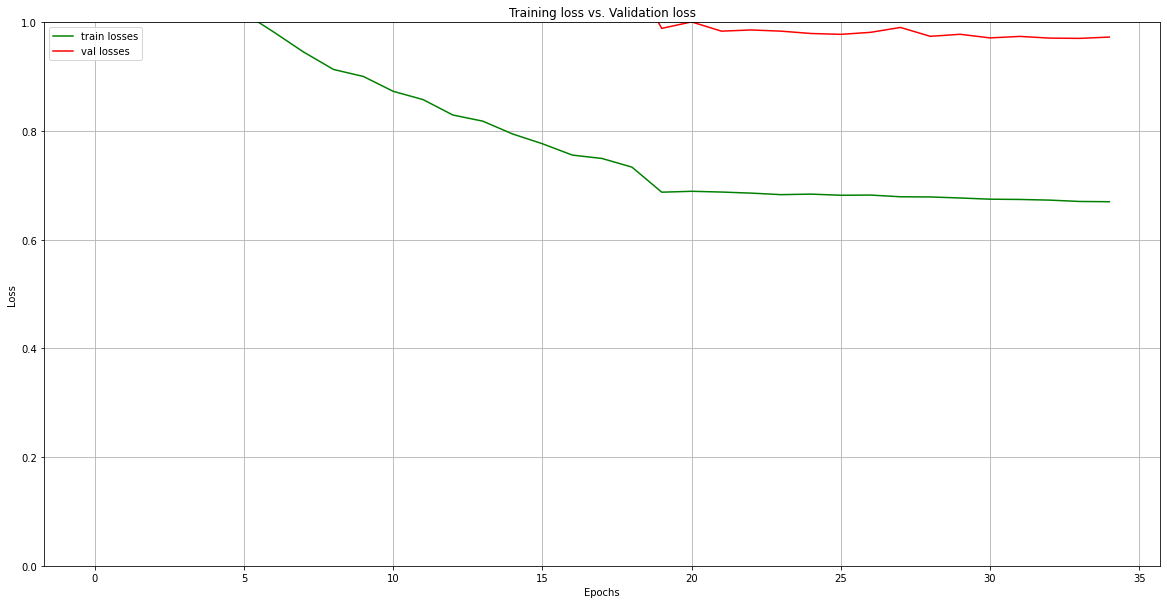

In [30]:
#Train FC Layer with transfer-learning to axial
case = 'meniscus' #set the case
train_fc_axial = TransferLearningModel(root_path,'axial', case, model_name, task='train')
start = timer()
history = train_fc_axial.train_fc(save_fc = True, memory = True)
end = timer()
train_fc_axial.plot_logs()
print(f'TRAINING FC LAYER - AXIAL FINISHED in {end - start}s')

loading 0000 features
loading 0001 features
loading 0002 features
loading 0003 features
loading 0004 features
loading 0005 features
loading 0006 features
loading 0007 features
loading 0008 features
loading 0009 features
loading 0010 features
loading 0011 features
loading 0012 features
loading 0013 features
loading 0014 features
loading 0015 features
loading 0016 features
loading 0017 features
loading 0018 features
loading 0019 features
loading 0020 features
loading 0021 features
loading 0022 features
loading 0023 features
loading 0024 features
loading 0025 features
loading 0026 features
loading 0027 features
loading 0028 features
loading 0029 features
loading 0030 features
loading 0031 features
loading 0032 features
loading 0033 features
loading 0034 features
loading 0035 features
loading 0036 features
loading 0037 features
loading 0038 features
loading 0039 features
loading 0040 features
loading 0041 features
loading 0042 features
loading 0043 features
loading 0044 features
loading 00

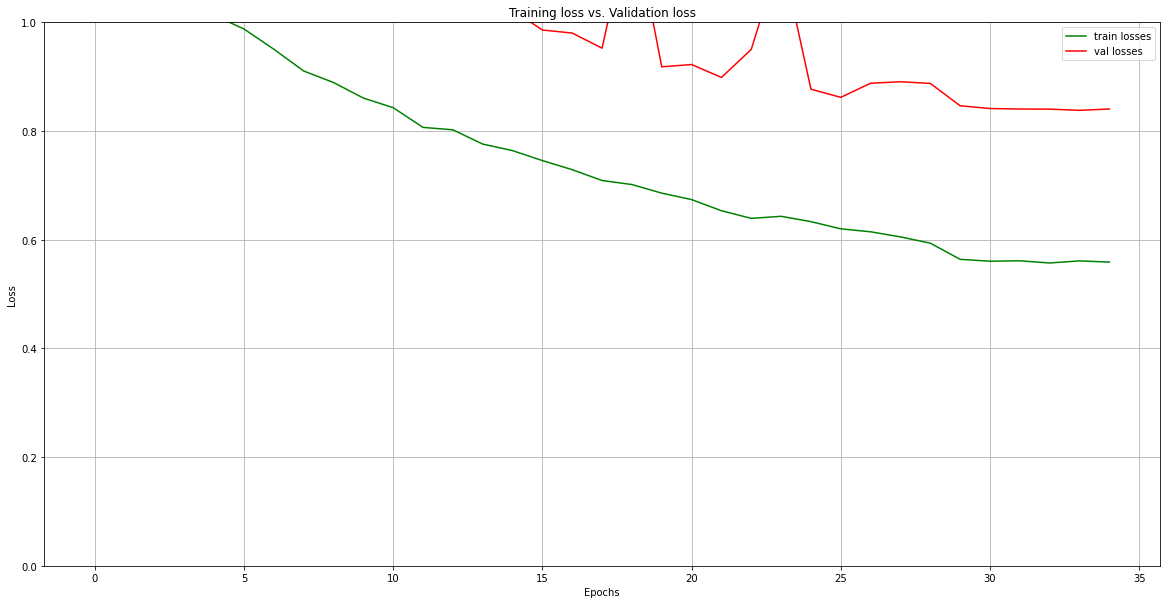

In [31]:
#Train FC Layer with transfer-learning to coronal

train_fc_coronal = TransferLearningModel(root_path,'coronal', case, model_name, task='train')
start = timer()
history = train_fc_coronal.train_fc(save_fc = True, memory = True)
end = timer()
train_fc_coronal.plot_logs()
print(f'TRAINING FC LAYER - CORONAL FINISHED in {end - start}s')

loading 0000 features
loading 0001 features
loading 0002 features
loading 0003 features
loading 0004 features
loading 0005 features
loading 0006 features
loading 0007 features
loading 0008 features
loading 0009 features
loading 0010 features
loading 0011 features
loading 0012 features
loading 0013 features
loading 0014 features
loading 0015 features
loading 0016 features
loading 0017 features
loading 0018 features
loading 0019 features
loading 0020 features
loading 0021 features
loading 0022 features
loading 0023 features
loading 0024 features
loading 0025 features
loading 0026 features
loading 0027 features
loading 0028 features
loading 0029 features
loading 0030 features
loading 0031 features
loading 0032 features
loading 0033 features
loading 0034 features
loading 0035 features
loading 0036 features
loading 0037 features
loading 0038 features
loading 0039 features
loading 0040 features
loading 0041 features
loading 0042 features
loading 0043 features
loading 0044 features
loading 00

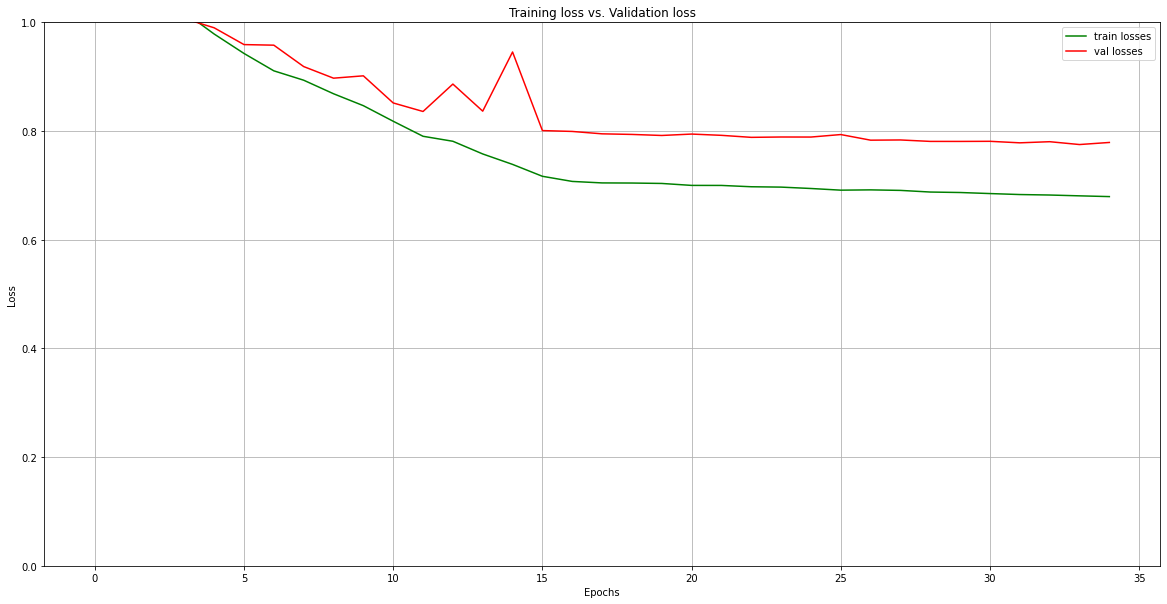

In [32]:
#Train FC Layer with transfer-learning to sagittal

train_fc_sagittal = TransferLearningModel(root_path,'sagittal', case, model_name, task='train')
start = timer()
history = train_fc_sagittal.train_fc(save_fc = True, memory = True)
end = timer()
train_fc_sagittal.plot_logs()
print(f'TRAINING FC LAYER - SAGITTAL FINISHED in {end - start}s')

Evaluating the fc layer:

In [34]:
#Evaluate views with Transfer Learning
model_name = 'vgg16'
features_dim = 512 #Output of the CNN dimensions (e.g. Vgg->512, Resnet/inception->2048)

view = 'axial'
records = pd.read_csv(root_path + f"/valid-{case}.csv", header=None, names=['id', 'label'])
Y = records['label'].to_numpy()

X = np.empty((0, features_dim))

for i in range(1130, 1250):
  index = '0' * (4 - len(str(i))) + str(i)
  path = root_path + f"/valid/{view}/{model_name}/{index}.npy"
  print('loading', index, 'features')
  x = np.load(path).reshape((1, features_dim))
  X = np.concatenate((X, x), axis = 0)

print(train_fc_axial.fc.evaluate(X, Y))

view = 'coronal'

records = pd.read_csv(root_path + f"/valid-{case}.csv", header=None, names=['id', 'label'])
Y = records['label'].to_numpy()

X = np.empty((0, features_dim))

for i in range(1130, 1250):
  index = '0' * (4 - len(str(i))) + str(i)
  path = root_path + f"/valid/{view}/{model_name}/{index}.npy"
  print('loading', index, 'features')
  x = np.load(path).reshape((1, features_dim))
  X = np.concatenate((X, x), axis = 0)

print(train_fc_coronal.fc.evaluate(X, Y))

view = 'sagittal'

records = pd.read_csv(root_path + f"/valid-{case}.csv", header=None, names=['id', 'label'])
Y = records['label'].to_numpy()

X = np.empty((0, features_dim))

for i in range(1130, 1250):
  index = '0' * (4 - len(str(i))) + str(i)
  path = root_path + f"/valid/{view}/{model_name}/{index}.npy"
  print('loading', index, 'features')
  x = np.load(path).reshape((1, features_dim))
  X = np.concatenate((X, x), axis = 0)

print(train_fc_sagittal.fc.evaluate(X, Y))

loading 1130 features
loading 1131 features
loading 1132 features
loading 1133 features
loading 1134 features
loading 1135 features
loading 1136 features
loading 1137 features
loading 1138 features
loading 1139 features
loading 1140 features
loading 1141 features
loading 1142 features
loading 1143 features
loading 1144 features
loading 1145 features
loading 1146 features
loading 1147 features
loading 1148 features
loading 1149 features
loading 1150 features
loading 1151 features
loading 1152 features
loading 1153 features
loading 1154 features
loading 1155 features
loading 1156 features
loading 1157 features
loading 1158 features
loading 1159 features
loading 1160 features
loading 1161 features
loading 1162 features
loading 1163 features
loading 1164 features
loading 1165 features
loading 1166 features
loading 1167 features
loading 1168 features
loading 1169 features
loading 1170 features
loading 1171 features
loading 1172 features
loading 1173 features
loading 1174 features
loading 11

Then, we train the classifier layer which produces the final output:

loading 0000 features
loading 0001 features
loading 0002 features
loading 0003 features
loading 0004 features
loading 0005 features
loading 0006 features
loading 0007 features
loading 0008 features
loading 0009 features
loading 0010 features
loading 0011 features
loading 0012 features
loading 0013 features
loading 0014 features
loading 0015 features
loading 0016 features
loading 0017 features
loading 0018 features
loading 0019 features
loading 0020 features
loading 0021 features
loading 0022 features
loading 0023 features
loading 0024 features
loading 0025 features
loading 0026 features
loading 0027 features
loading 0028 features
loading 0029 features
loading 0030 features
loading 0031 features
loading 0032 features
loading 0033 features
loading 0034 features
loading 0035 features
loading 0036 features
loading 0037 features
loading 0038 features
loading 0039 features
loading 0040 features
loading 0041 features
loading 0042 features
loading 0043 features
loading 0044 features
loading 00

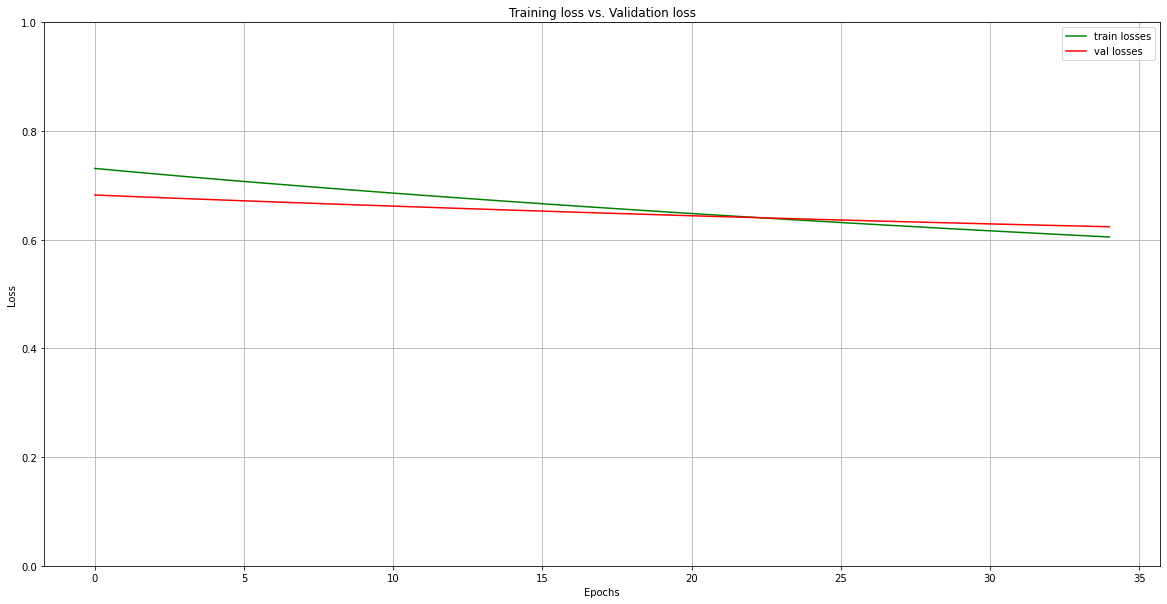

In [35]:
#Get the predictions for axial
axial_predict = TransferLearningModel(root_path,'axial', case, model_name, task='train')
start = timer()
axial_predictions = axial_predict.predict_fc()
end = timer()
print(f'PREDICTING FC LAYER - AXIAL FINISHED in {end - start}s')

#Get the predictions for coronal
coronal_predict = TransferLearningModel(root_path,'coronal', case, model_name, task='train')
start = timer()
coronal_predictions = coronal_predict.predict_fc()
end = timer()
print(f'PREDICTING FC LAYER - CORONAL FINISHED in {end - start}s')

#Get the predictions for sagittal
sagittal_predict = TransferLearningModel(root_path,'sagittal', case, model_name, task='train')
start = timer()
sagittal_predictions = sagittal_predict.predict_fc()
end = timer()
print(f'PREDICTING FC LAYER - SAGITTAL FINISHED in {end - start}s')


#Define the layer
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
  min_delta=0,
  patience=5,
  verbose=0, mode='auto',
  restore_best_weights=True
)
    
reduce_lr = keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss', factor=0.1, patience=3, verbose=0, mode='auto',
  min_delta=0, cooldown=0, min_lr=1e-5
)
inputs = keras.Input((3,))
outputs = keras.layers.Dense(1, activation='sigmoid')(inputs)
classifier_model = keras.Model(inputs, outputs)
classifier_model.compile(
  optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=[keras.metrics.AUC()]
  )

Xp = np.concatenate((axial_predictions, coronal_predictions, sagittal_predictions), axis=1) #this is the input to sigmoid function
records = pd.read_csv(root_path + f"/train-{case}.csv", header=None, names=['id', 'label'])
Y = records['label'].to_numpy()


history = classifier_model.fit(
  x=Xp, y=Y, batch_size=1, epochs=35, verbose=2, callbacks=[reduce_lr, early_stopping],
  validation_split=0.1, validation_data=None, shuffle=True,
)
train_classifier_logs = history.history

plot_logs(train_classifier_logs, root_path + f'/figures/{model_name}-classifier-{case}.png')

classifier_model.save(root_path + f'/models/{model_name}-auc-classifier-{case}.h5')
with open(root_path + f'/models/{model_name}-auc-classifier-{case}-history', 'wb') as file_pi:
      pickle.dump(train_classifier_logs, file_pi)

Evaluating the classifier:

In [36]:
classifier_model = keras.models.load_model(root_path + f'/models/{model_name}-auc-classifier-abnormal.h5')

axial_predict = TransferLearningModel(root_path,'axial', case, model_name, task='valid')
axial_predict.fc.summary()
start = timer()
axial_predictions = axial_predict.predict_fc()
end = timer()
print(f'PREDICTING FC LAYER - AXIAL FINISHED in {end - start}s')

coronal_predict = TransferLearningModel(root_path,'coronal', case, model_name, task='valid')
coronal_predict.fc.summary()
start = timer()
coronal_predictions = coronal_predict.predict_fc()
end = timer()
print(f'PREDICTING FC LAYER - CORONAL FINISHED in {end - start}s')

sagittal_predict = TransferLearningModel(root_path,'sagittal', case, model_name, task='valid')
sagittal_predict.fc.summary()
start = timer()
sagittal_predictions = sagittal_predict.predict_fc()
end = timer()
print(f'PREDICTING FC LAYER - SAGITTAL in {end - start}s')

Xp_val = np.concatenate((axial_predictions, coronal_predictions, sagittal_predictions), axis=1) #this is the input to sigmoid function
records = pd.read_csv(root_path + f"/valid-{case}.csv", header=None, names=['id', 'label'])
Y_val = records['label'].to_numpy()

Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_112 (InputLayer)       [(None, 512)]             0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
loading 1130 features
loading 1131 features
loading 1132 features
loading 1133 features
loading 1134 features
loading 1135 features
loading 1136 features
loading 1137 features
loading 1138 features
loading 1139 features
loading 1140 features
loading 1141 features
loading 1142 features
loading 1143 features
loading 1144 features
loading 1145 features
loading 1146 features
loading 1147 features
loading 1148 features
loading 1149 features
loading 1150 features
loading 1151 features
loading 1152 features
loading 1153 fea

In [37]:
history_eval = classifier_model.evaluate(
    x=Xp_val, y=Y_val, verbose=2
)

4/4 - 0s - loss: 0.7871 - auc_3: 0.7309


In [0]:
"""
InceptionV3:
 abnormal:
  Axial: AUC 84%
  Coronal: AUC 84%
  Sagittal: AUC 83%
  Classifier: AUC 90%

 acl
  Axial: AUC 83%
  Coronal: AUC 80%
  Sagittal: AUC 79%
  Classifier: AUC 87%

 meniscus
  Axial: AUC 69%%
  Coronal: AUC 75%
  Sagittal: AUC 78%
  Classifier: AUC 77%



ResNet
 abnormal:
  Axial: AUC 89%
  Coronal: AUC 85%
  Sagittal: AUC 94%
  Classifier: AUC 87%

 acl
  Axial: AUC 88%
  Coronal: AUC 82%
  Sagittal: AUC 86%
  Classifier: AUC 82%

 meniscus
  Axial: AUC 73%%
  Coronal: AUC 78%
  Sagittal: AUC 71%
  Classifier: AUC 77%

VGG16
 abnormal:
  Axial: AUC 77%
  Coronal: AUC 76%
  Sagittal: AUC 88%
  Classifier: AUC 75%

 acl
  Axial: AUC 75%
  Coronal: AUC 76%
  Sagittal: AUC 79%
  Classifier: AUC 78%

 meniscus
  Axial: AUC 63%
  Coronal: AUC 78%
  Sagittal: AUC 65%
  Classifier: AUC 73%
"""
